<a href="https://colab.research.google.com/github/BC-Chang/intro_to_pytorch/blob/master/Intro_to_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
!pip install lightning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.4/40.4 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 24.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 72.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 58.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 47.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 821.8 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 86.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim

import lightning as pl

from sklearn.model_selection import train_test_split

import numpy as np

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

## Our model
Let's say we want to train the neural network from the example slides:

<img src="https://raw.githubusercontent.com/BC-Chang/intro_to_pytorch/master/figures/oil_water_classifier.png" height="300">


Here, we have:
- 2 input features ($\nu$ and $\rho$),
- 3 nodes in the hidden layer
- 2 output layer nodes

The aim of the model is to predict whether a given fluid is oil or water given it's kinematic viscosity and density.


## Training Data
Let's make some mock training data first. Assume our fluids are 48&deg; API crude oil and water at ~16&deg;C.

Note that we can relate API gravity to density by

$API = \frac{141.5}{SG} - 131.5$



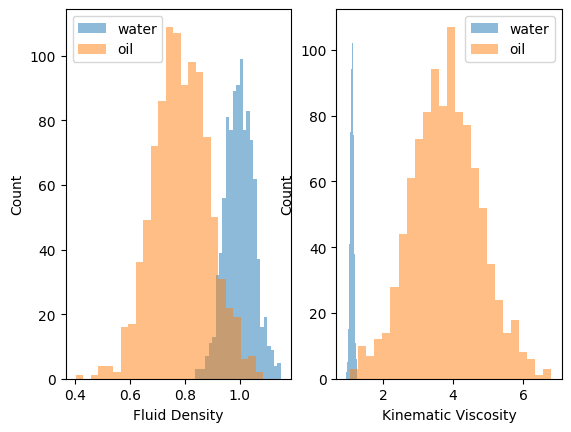

In [3]:
np.random.seed(13675401)

dataset_size = 1000

# Generate random numbers for properties of water
rho_w = np.random.normal(loc=0.999, scale=0.05, size=(dataset_size,1))
nu_w = np.random.normal(loc=1.1088, scale=0.05, size=(dataset_size,1))

# Generate random numbers for property of crude oil\
rho_o_mean = 141.5/(48 + 131.5)
rho_o = np.random.normal(loc=rho_o_mean, scale=0.1, size=(dataset_size,1))
nu_o = np.random.normal(loc=3.8, scale=1, size=(dataset_size,1))

# Plot the histograms
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.hist(rho_w, bins=25, alpha=0.5, label='water')
ax1.hist(rho_o, bins=25, alpha=0.5, label='oil')
ax1.set_xlabel('Fluid Density')
ax1.set_ylabel('Count')
ax1.legend()

ax2.hist(nu_w, bins=25, alpha=0.5, label='water')
ax2.hist(nu_o, bins=25, alpha=0.5, label='oil')
ax2.set_xlabel('Kinematic Viscosity')
ax2.set_ylabel('Count')
ax2.legend()

In [4]:
# Combine the data and shuffle
water_labels = np.zeros((dataset_size,1))
oil_labels = np.ones((dataset_size,1))

oil_data = np.concatenate((rho_o, nu_o), axis=1)
water_data = np.concatenate((rho_w, nu_w), axis=1)

inputs = np.concatenate((oil_data, water_data), axis=0)
labels = np.concatenate((oil_labels, water_labels), axis=0)

dataset = np.concatenate((inputs, labels), axis=1)

np.random.shuffle(dataset)
inputs = dataset[:, :-1]
labels = dataset[:, -1]

print(f"{inputs.shape = }")
print(f"{labels.shape = }")


inputs.shape = (2000, 2)
labels.shape = (2000,)


In [5]:
# Split our data into training/validation

x_train, x_val, y_train, y_val = train_test_split(inputs, labels, test_size=0.25, random_state=13580279)

# Convert the training data from numpy ndarray to torch tensor
x_train, x_val = [torch.as_tensor(data, dtype=torch.float32) for data in [x_train, x_val]]
y_train, y_val = [torch.as_tensor(data, dtype=torch.long) for data in [y_train, y_val]]


We will construct a PyTorch DataLoader to help with processing our data during training and inference.

Here we will put our training and validation data into separate DataLoaders via a custom ``Dataset()`` object. PyTorch also offers a default ``TensorDataset()`` object for simple data (like what we have).

Though this is not entirely necessary for this example, it is considered best practice.

In [6]:
class FluidDataset(Dataset):
  def __init__(self, x, y):
    self.x = x
    self.y = y

  def __len__(self):
    return len(self.y)

  def __getitem__(self, idx):
    return self.x[idx], self.y[idx]

In [7]:
train_dataset = FluidDataset(x_train, y_train)
val_dataset = FluidDataset(x_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False, pin_memory=True)

## Let's build our model in Pytorch

In PyTorch, a model is defined using a class that inherits from ``torch.nn.Module``. The class structure defines the architecture of the network, the forward pass (how the data moves through the layers), and how the parameters are initialized and updated throughout training.

The structure of each class is as follows:

1. Define a class that inherits from ``torch.nn.Module``.
2. Define the constructor (``def __init__(self)``).
  - This is where the layers of the neural network are defined.
  - We call ``super(XX, self).__init__()`` to initialize the parent class, ``nn.Module``, so that PyTorch can track all the parameters.
3. Define the forward method (``def forward(self, x)``).
  - The forward method defines how the inputs flows through the network.
  - ``x`` represents the input training data that is passed into the model

When constructing our model, notice that we have:
- an input layer that takes 2 inputs and is connected to 3 nodes in the hidden layer.
- a hidden layer that transforms our data using an activation function. Let's use the ReLU activation function, but this is somewhat arbitrary
- an output layer that makes the classification prediction. It takes 3 inputs from the hidden layer, and outputs 2 "probabilities" (though they are not technically probabilities yet).

## Training our model

Now that we have defined our model and created some training data, we can now train our model.

Recall that the aim of any ML model is to minimize some loss function. The way it does this is by:
1. Making an intermediate prediction (a forward pass through the model)
2. Computing the loss given some loss function
3. Backpropagating the loss through the model to compute gradients (using the chain rule)
4. Updating the model parameters according to the gradient values.

This process is repeated for all data in the training set, over $n$ epochs.

### Optimizers

Most simply, step 4 can be accomplished via gradient descent update rules:

$\theta^{t+1} \leftarrow \theta^t - \eta \nabla_\theta \mathcal{L}$,

where $\theta$ are the parameters, $t$ is the update step, $\eta$ is the learning rate, and $\nabla_\theta \mathcal{L}$ are the gradients computed from back propagation.

As discussed in the slides, we can update the parameters using an *optimizer*, rather than relying solely on gradient descent. Optimizers help speed up convergence and improve training performance and stability by including additional parameters in its update rules, such as adaptive learning rates and momentum.

Here, we will use the stochastic gradient descent optimizer (SGD).

### Training loop

Here we construct the training loop according to the steps listed above.

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
# Initialize the model
model = 


# Cross Entropy Loss function
loss_f = 

# Initialize Optimizer
optimizer = 

# Training loop
num_epochs = 50

for epoch in range(num_epochs):
  model.train()
  train_loss = 0.0

  # Training phase
  for x, y in train_loader:
    x, y = x.to(device), y.to(device)
    # Zero the gradients

    # Forward pass

    # Compute the loss

    # Backward pass: Compute gradients of the loss with respect to model parameters

    # Update the model's parameters


    train_loss += loss.item()

  train_loss = train_loss / len(train_loader)
  print(f"{train_loss = }")
  # Validate every 10 epochs
  if (epoch + 1) % 10 == 0:
    model.eval()
    val_loss = 0.0

    # Disable gradients for validation
    with torch.no_grad():
      for x, y in val_loader:
        x, y = x.to(device), y.to(device)
        yhat = 
        loss = 
        val_loss += loss.item()
    val_loss = val_loss / len(val_loader)
    print(f"{val_loss = }")


Using device: cuda
train_loss = 0.15364176903070256
train_loss = 0.039837194468822945
train_loss = 0.028862895403064835
train_loss = 0.02327738393416636
train_loss = 0.020574395839707292
train_loss = 0.01763506470613863
train_loss = 0.015987511261475025
train_loss = 0.014123275166858837
train_loss = 0.01315813122808988
train_loss = 0.011657643082035672
val_loss = 0.00950396534291835
train_loss = 0.010894590736804455
train_loss = 0.010142750194282756
train_loss = 0.009337584151635454
train_loss = 0.008568230657983093
train_loss = 0.00807007674310681
train_loss = 0.007605793274032569
train_loss = 0.007140714185485242
train_loss = 0.006639553104646926
train_loss = 0.00649341241725179
train_loss = 0.0061148429710419375
val_loss = 0.006874890795561114
train_loss = 0.005527670118661376
train_loss = 0.005532568993648089
train_loss = 0.005216033826273213
train_loss = 0.004949488058434601
train_loss = 0.004783344454070431
train_loss = 0.004688943965636322
train_loss = 0.004453797138710708
train

In [14]:
model.eval()
# Making predictions with the trained model
new_data = torch.tensor([1, 1], device=device, dtype=torch.float32)  # 5 new samples with 2 features each
predictions = model(new_data).view(1, -1) # Get model predictions
# Apply softmax if using CrossEntropyLoss (optional)
print(predictions)
probabilities = torch.softmax(predictions, dim=1)

# Convert logits to predicted class (0 or 1)
predicted_classes = torch.argmax(probabilities, dim=1)
print(predicted_classes)

tensor([[ 5.0428, -5.1705]], device='cuda:0', grad_fn=<ViewBackward0>)
tensor([0], device='cuda:0')


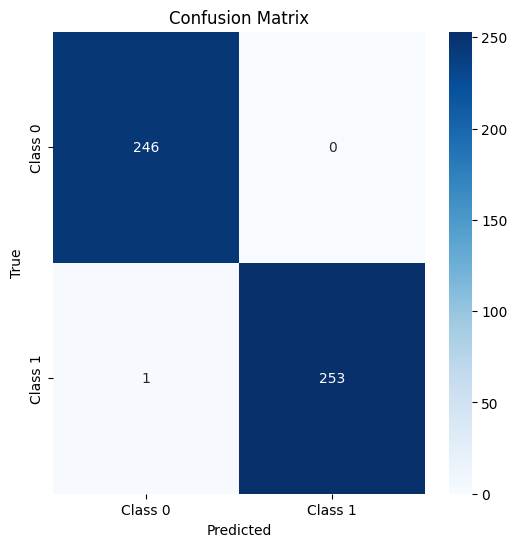

In [15]:
# Assuming you have your model and val_loader already defined
model.eval()  # Switch to evaluation mode

y_true = []
y_pred = []

# Make predictions with val_loader
with torch.no_grad():  # Disable gradient computation for inference
    for x, y in val_loader:
        # Move data to the device if you're using GPU
        x, y = x.to(device), y.to(device)

        # Forward pass
        outputs = model(x)

        # Get predictions (class with highest probability)
        _, predicted = torch.max(outputs, 1)

        # Store true labels and predicted labels
        y_true.extend(y.cpu().numpy())  # Move data to CPU before converting to numpy
        y_pred.extend(predicted.cpu().numpy())

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='inferno', xticklabels=['Water', 'Oil'], yticklabels=['Water', 'Oil'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


Great! We have now successfully trained our Fluid Classifier model!


## PyTorch Lightning
Setting up the training loop seemed a little tedious. It can get more complicated when trying to handle more complex training, such as using multiple GPUs, logging, checkpointing, etc.

Luckily, there are several high-level wrappers that take care a lot of boilerplate code for us! (e.g., Lightning, FastAI, Horovod, etc.)

Here we will be using PyTorch Lightning.

### How does PyTorch Lightning work?

Typical Lightning workflows revolve around defining a ``LightningModule`` object. This is a class that encapsulates the model architecture, training loop, and validation logic.

The Lightning module is structured similarly to the ``nn.Module``. Key components include:

- ``__init__(self)``: A constructor where the model (or model layers), loss function, optimizers, and any other components are defined.
- ``forward(self, x)``: Defines the forward pass, similar to how we did it in the FluidClassifier class
- ``training_step(self, batch, batch_idx)``: Defines a training step.
  - Perform a forward step, calculate the loss, and return the loss value. Lightning handles the backpropagation and parameter updates

- ``validation_step(self, batch, batch_idx)``: Similar to the prediction step, but is called by Lightning in the validation phase

- ``test_step(self)`` / ``predict_step(self)``: Used for predicting on the test set.
  - Use ``test_step(self)`` when computing loss metrics on the test data
  - Use ``predict_step(self)`` for generating predictions without calculating loss.

- ``configure_optimizers(self)``: Defines the optimizer (and LR scheduler) to use for training.

In this example, we also include a ``on_test_epoch_end(self)`` function to plot the confusion matrix after testing.

### Extending our FluidClassifier model to use Lightning.

**Note**: Because we have already defined the architecture of FluidClassifier, we do not need to entirely redefine it in the Lightning module.

In [60]:
class LightningFluidClassifier(pl.LightningModule):
  def __init__(self):
    super(LightningFluidClassifier, self).__init__()

    # Define the model (here we can just use our previous definition)
    self.model = 

    # Define the loss function
    self.loss_f = 

    # Define lists for test predictions
    self.test_y = []
    self.test_yhat = []

  def forward(self, x):
    pass

  def training_step(self, batch, batch_idx):
    x, y = batch
    # Forward Pass
    yhat = 
    # Calculate loss
    loss = 
    return loss

  def validation_step(self, batch, batch_idx):
    x, y, = batch
    # Forward Pass
    yhat = 
    # Calculate loss
    loss =
    return loss

  def test_step(self, batch, batch_idx):
    x, y, = batch
    # Forward Pass
    yhat = 
    # Calculate loss
    loss = 

    # Compute probabilities from logits
    probabilities = 

    self.test_y.append(y)
    self.test_yhat.append(probabilities)

    return {"loss": loss, "predictions": probabilities, "labels": y}

  def on_test_epoch_end(self):
    y_hat = torch.cat(self.test_yhat)
    y = torch.cat(self.test_y)

    # Convert to numpy arrays
    y_hat = y_hat.argmax(dim=1).cpu().numpy()
    y = y.cpu().numpy()

    # Compute the confusion matrix
    cm = confusion_matrix(y, y_hat)

    plt.figure(figsize=(6,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='inferno', xticklabels=['Water', 'Oil'], yticklabels=['Water', 'Oil'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    return

  def configure_optimizers(self):
    optimizer = 
    return optimizer



## Training our model with Lightning

Now that our Lightning module is defined, we can begin training.

Instead of having to manually write the training loop, Lightning handles all that logic for us! All we need to do is

1. Instantiate the ``LightningFluidClassifier`` object
2. Instantiate a Lightning Trainer
3. Run ``model.fit()``


In [61]:
# Instantiate the Lightning FluidClassifier object
lightning_model = 

# Instantiate a Lightning Trainer
trainer = 

# Fit the model


INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name   | Type             | Params | Mode 
----------------------------------------------------
0 | model  | FluidClassifier  | 17     | train
1 | loss_f | CrossEntropyLoss | 0      | train
----------------------------------------------------
17        Trainable params
0         Non-trainable params
17        Total params
0.000     Total estimated model params size (MB)
5         Modules in train mode
0         Modules in eval mode
INFO:lightning.pytorch.callbacks.model_summ

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=2` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=2` reached.


## Testing our Lightning Model

Now that we have trained our model with Lightning, we can evaluate it on our validation set using Lightning as well!



INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

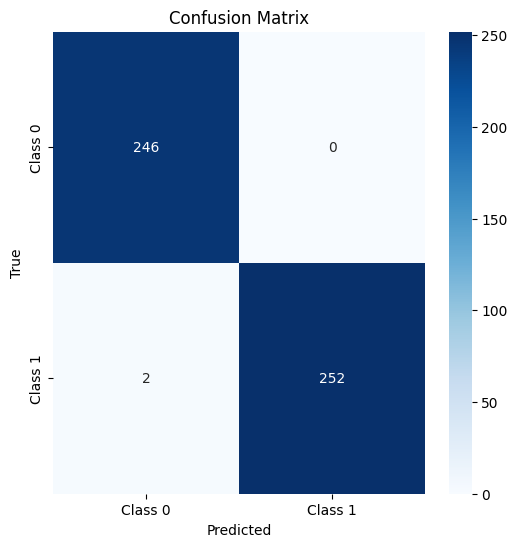

In [62]:
# Evaluate the model on the validation set
test_results = 